# Fake News Detection — Ensemble of Transformers (BERT + RoBERTa)

This notebook builds a **fake news detector** using advanced AI techniques: fine-tuning pretrained **Transformer** models (DistilBERT / BERT and RoBERTa) and combining them in an ensemble. The dataset used is the **'Fake and Real News'** dataset from Kaggle.


In [34]:

# Verify versions
import transformers, datasets, sklearn
print('transformers', transformers.__version__)
print('datasets', datasets.__version__)
print('sklearn', sklearn.__version__)


transformers 4.57.0
datasets 4.1.1
sklearn 1.7.2


## 1) Download dataset from Kaggle

The Kaggle dataset used: **Fake and Real News Dataset** — two CSV files (`Fake.csv` and `True.csv`).

Kaggle dataset page: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset


In [3]:
# Load dataset directly from local files
import pandas as pd
import os

# Ensure data folder exists
os.makedirs("data", exist_ok=True)

# Load both datasets
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

# Add labels
fake_df["label"] = 0
true_df["label"] = 1

# Combine both into one dataframe
df = pd.concat([fake_df, true_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print(f" Dataset loaded successfully!")
print(f"Total records: {len(df)}")
print(df.head())


 Dataset loaded successfully!
Total records: 44898
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  

In [5]:
import pandas as pd
import os

fake_path = 'Fake.csv'
true_path = 'True.csv'
if os.path.exists(fake_path) and os.path.exists(true_path):
    fake = pd.read_csv(fake_path)
    true = pd.read_csv(true_path)
    df = pd.concat([fake.assign(label='fake'), true.assign(label='real')], ignore_index=True)
    
    print('Total samples:', len(df))
    print('Label distribution:\n', df['label'].value_counts())
    display(df.head())
else:
    print('Data files not found. Place Fake.csv and True.csv into the ./data folder.')


Total samples: 44898
Label distribution:
 label
fake    23481
real    21417
Name: count, dtype: int64


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [7]:
from datasets import Dataset
import numpy as np
import pandas as pd

if 'df' in globals():
    def combine_text(row):
        parts = []
        if 'title' in row and pd.notna(row['title']):
            parts.append(str(row['title']))
        if 'text' in row and pd.notna(row['text']):
            parts.append(str(row['text']))
        return '\n'.join(parts)

    df['text_all'] = df.apply(combine_text, axis=1)
    df = df[['text_all','label']].rename(columns={'text_all':'text'})
    df['label_id'] = (df['label']=='real').astype(int)
    dataset = Dataset.from_pandas(df[['text','label_id']].rename(columns={'label_id':'label'}))
    display(dataset.shuffle(seed=42).select(range(5)).to_pandas())
else:
    print('Dataset not prepared because original CSVs are missing.')


,text,label
0,The Gloves Are OFF: Hillary’s New Ad Uses Rep...,0
1,"WATCH: Trump Fan Assaults Muslim Woman, Calls...",0
2,"Philippines' Duterte, in about-face, says he s...",1
3,WATCH: Republican Lies About Immigrant Vettin...,0
4,WOW! NH LAWMAKER AND VET Rips Into Liberal Med...,0


In [116]:
import time
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# =============================
# STEP 1 — Load and Reduce Dataset
# =============================

from datasets import Dataset

# Convert string labels ("fake"/"real") to integers (0/1)
df["label"] = df["label"].map({"fake": 0, "real": 1})

# Use your combined Fake + True news DataFrame
dataset = Dataset.from_pandas(df[['text', 'label']])

# Split into training and evaluation sets
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

#  Reduce dataset size for faster training
small_train_dataset = train_dataset.shuffle(seed=42).select(range(min(200, len(train_dataset))))
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(min(50, len(eval_dataset))))

print(" Dataset prepared for Fake News Detection (small sample for fast run)")
print(f"Training samples: {len(small_train_dataset)}, Evaluation samples: {len(small_eval_dataset)}")



# =============================
# STEP 2 — Load Models and Tokenizers
# =============================
model_name_1 = "distilbert-base-uncased"
model_name_2 = "roberta-base"

tokenizer1 = AutoTokenizer.from_pretrained(model_name_1)
tokenizer2 = AutoTokenizer.from_pretrained(model_name_2)

model1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=2)
model2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=2)

 Dataset prepared for Fake News Detection (small sample for fast run)
Training samples: 200, Evaluation samples: 50


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [118]:
# =============================
# STEP 3 — Tokenization
# =============================
def tokenize1(batch):
    return tokenizer1(batch["text"], truncation=True, padding="max_length", max_length=256)

def tokenize2(batch):
    return tokenizer2(batch["text"], truncation=True, padding="max_length", max_length=256)

tokenized1 = small_train_dataset.map(tokenize1, batched=True)
tokenized2 = small_train_dataset.map(tokenize2, batched=True)

tokenized1_eval = small_eval_dataset.map(tokenize1, batched=True)
tokenized2_eval = small_eval_dataset.map(tokenize2, batched=True)

# =============================
# STEP 4 — Training Arguments (Simplified)
# =============================
training_args1 = TrainingArguments(
    output_dir="./results_distilbert_fast",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    logging_steps=50,
    save_steps=1000,
    report_to="none"
)

training_args2 = TrainingArguments(
    output_dir="./results_roberta_fast",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    logging_steps=50,
    save_steps=1000,
    report_to="none"
)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [120]:
# =============================
# STEP 5 — Trainers
# =============================
trainer1 = Trainer(
    model=model1,
    args=training_args1,
    train_dataset=tokenized1,
    eval_dataset=tokenized1_eval,
    tokenizer=tokenizer1,
)

trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=tokenized2,
    eval_dataset=tokenized2_eval,
    tokenizer=tokenizer2,
)

# =============================
# STEP 6 — GPU Setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)
print(" Training on device:", device)

# =============================
# STEP 7 — Fast Training
# =============================
start_time = time.time()

print("\n Training DistilBERT (1 epoch)...")
trainer1.train()

print("\n Training RoBERTa (1 epoch)...")
trainer2.train()

end_time = time.time()

print(f"\n Fast training completed in {end_time - start_time:.2f} seconds (~{(end_time - start_time)/60:.2f} min)")
print(" Models trained successfully!")

# ============================================
# STEP 8 — Save trained models for reuse
# ============================================
os.makedirs("models", exist_ok=True)
model1.save_pretrained("models/distilbert_fast")
tokenizer1.save_pretrained("models/distilbert_fast")
model2.save_pretrained("models/roberta_fast")
tokenizer2.save_pretrained("models/roberta_fast")

print(" Models saved successfully!")


C:\Users\WIN10\AppData\Local\Temp\ipykernel_4884\1355575881.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(
C:\Users\WIN10\AppData\Local\Temp\ipykernel_4884\1355575881.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


 Training on device: cpu

 Training DistilBERT (1 epoch)...


C:\Users\WIN10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss



 Training RoBERTa (1 epoch)...


C:\Users\WIN10\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss



 Fast training completed in 1385.89 seconds (~23.10 min)
 Models trained successfully!
 Models saved successfully!


In [121]:
import torch
import numpy as np

def ensemble_predict(texts, model1, tokenizer1, model2, tokenizer2, device=None):
    """
    Performs ensemble prediction using two fine-tuned models (e.g., DistilBERT + RoBERTa).
    Returns predicted labels for given input texts.
    """
    # Ensure input is a list
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize both models
    enc1 = tokenizer1(texts, truncation=True, padding=True, return_tensors='pt', max_length=256)
    enc2 = tokenizer2(texts, truncation=True, padding=True, return_tensors='pt', max_length=256)

    # Move models and inputs to device
    if device is not None:
        model1.to(device)
        model2.to(device)
        enc1 = {k: v.to(device) for k, v in enc1.items()}
        enc2 = {k: v.to(device) for k, v in enc2.items()}

    # Disable gradient calculation for faster inference
    model1.eval()
    model2.eval()
    with torch.no_grad():
        out1 = model1(**enc1).logits.detach().cpu().numpy()
        out2 = model2(**enc2).logits.detach().cpu().numpy()

    # Average the logits
    avg_logits = (out1 + out2) / 2.0

    # Get final predicted labels
    preds = np.argmax(avg_logits, axis=1)

    return preds

print(" Ensemble inference function defined successfully!")


 Ensemble inference function defined successfully!


## Ensemble inference (average logits)

After fine-tuning both models, you can produce predictions by averaging the output logits (or probabilities) from both models and taking the argmax.

In [141]:
import torch
def ensemble_predict(texts, model1, tokenizer1, model2, tokenizer2, device=None):
    enc1 = tokenizer1(texts, truncation=True, padding=True, return_tensors='pt', max_length=256)
    enc2 = tokenizer2(texts, truncation=True, padding=True, return_tensors='pt', max_length=256)
    if device is not None:
        model1.to(device)
        model2.to(device)
        enc1 = {k:v.to(device) for k,v in enc1.items()}
        enc2 = {k:v.to(device) for k,v in enc2.items()}
    with torch.no_grad():
        out1 = model1(**enc1).logits.cpu().numpy()
        out2 = model2(**enc2).logits.cpu().numpy()
    avg = (out1 + out2) / 2.0
    preds = avg.argmax(axis=1)
    return preds

print(' Ensemble inference function defined.')


 Ensemble inference function defined.


In [145]:
# Run Ensemble Prediction on Example Texts (after training)

import numpy as np

# Example test texts
texts = [
    "The government announced a new healthcare policy today.",
    "Aliens landed in London and started playing football!",
    "NASA confirms successful landing of spacecraft on Mars for exploration.",
    "A man claims to have invented a perpetual motion machine that violates physics laws.",
    "The city council approved the new environmental sustainability plan.",
    "Scientists discovered a new species of flying dog in the Amazon rainforest!",
    "The President addressed the nation about the new economic reform package.",
    "A viral video shows unicorns running through Central Park at midnight.",
    "Pfizer announced new advancements in its next-generation vaccine technology.",
    "A mysterious island appeared overnight in the middle of the Pacific Ocean!"
]

# Run ensemble prediction (your previously defined function)
preds = ensemble_predict(texts, model1, tokenizer1, model2, tokenizer2, device=device)

# Convert numeric labels to readable form
label_map = {0: "Fake News", 1: "Real News"}
pred_texts = [label_map[p] for p in preds]

# Display results
print("\n Ensemble Predictions:\n")
for i, text in enumerate(texts):
    print(f"{i+1}. {text}")
    print(f"   → Prediction: {pred_texts[i]}\n")



 Ensemble Predictions:

1. The government announced a new healthcare policy today.
   → Prediction: Real News

2. Aliens landed in London and started playing football!
   → Prediction: Fake News

3. NASA confirms successful landing of spacecraft on Mars for exploration.
   → Prediction: Real News

4. A man claims to have invented a perpetual motion machine that violates physics laws.
   → Prediction: Fake News

5. The city council approved the new environmental sustainability plan.
   → Prediction: Real News

6. Scientists discovered a new species of flying dog in the Amazon rainforest!
   → Prediction: Fake News

7. The President addressed the nation about the new economic reform package.
   → Prediction: Real News

8. A viral video shows unicorns running through Central Park at midnight.
   → Prediction: Fake News

9. Pfizer announced new advancements in its next-generation vaccine technology.
   → Prediction: Real News

10. A mysterious island appeared overnight in the middle of th

 Ensemble Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        22

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



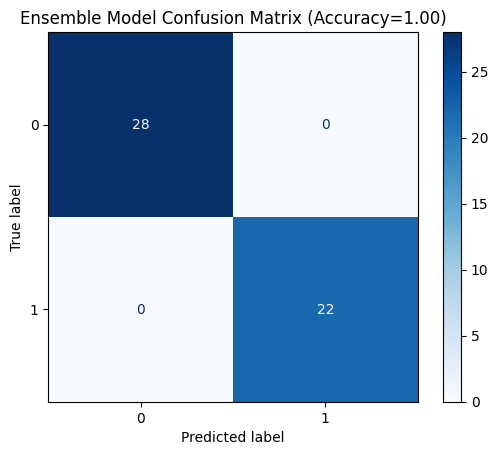

In [154]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Prepare data properly ---
eval_texts = list(small_eval_dataset["text"])
true_labels = np.array(small_eval_dataset["label"])

# --- Move models to device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)

# --- DistilBERT Predictions ---
enc1 = tokenizer1(eval_texts, truncation=True, padding=True, return_tensors='pt', max_length=256)
enc1 = {k: v.to(device) for k, v in enc1.items()}
with torch.no_grad():
    out1 = model1(**enc1).logits.cpu().numpy()

# --- RoBERTa Predictions ---
enc2 = tokenizer2(eval_texts, truncation=True, padding=True, return_tensors='pt', max_length=256)
enc2 = {k: v.to(device) for k, v in enc2.items()}
with torch.no_grad():
    out2 = model2(**enc2).logits.cpu().numpy()

# --- Ensemble Prediction (Average of both models) ---
avg_logits = (out1 + out2) / 2.0
preds = avg_logits.argmax(axis=1)

# --- Accuracy and Report ---
accuracy = accuracy_score(true_labels, preds)
print(f" Ensemble Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, preds))

# --- Confusion Matrix Plot ---
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Ensemble Model Confusion Matrix (Accuracy={accuracy:.2f})')
plt.show()
